In [1]:
import librosa
from IPython.display import Audio, display
import numpy as np
from dtaidistance import dtw_ndim
import matplotlib.pyplot as plt

def preprocess_audio(audio_path, sr=16000):
    y, sr = librosa.load(audio_path, sr=sr)
    y = librosa.to_mono(y)
    y, _ = librosa.effects.trim(y, top_db=25)
    y = y / np.max(np.abs(y))

    return y, sr

def extract_mfcc_pitch(y, sr, n_mfcc=20):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = mfcc.T  # (time, mfcc)
    mfcc = (mfcc - np.mean(mfcc, axis=0)) / np.std(mfcc, axis=0)  # Cepstral Mean Variance Normalization

    pitch = librosa.yin(y, fmin=50,fmax=300, sr=sr)
    pitch = pitch.reshape(-1, 1)  # (time, 1)

    min_len = min(len(mfcc), len(pitch))
    features = np.hstack((mfcc[:min_len], pitch[:min_len]))

    return features


def dtw_alignment(features_native, features_learner):
    distance = dtw_ndim.distance(features_native, features_learner, use_c=True)

    path = dtw_ndim.warping_path(features_native, features_learner)

    aligned_native = []
    aligned_learner = []

    for i, j in path:
        aligned_native.append(features_native[i])
        aligned_learner.append(features_learner[j])

    return np.array(aligned_native), np.array(aligned_learner), distance


def pronunciation_score(aligned_native, aligned_learner):
    distances = np.linalg.norm(aligned_native - aligned_learner, axis=1)  # Euclidean distance per frame
    avg_distance = np.mean(distances)

    score = max(0, 100 - avg_distance)  # Convert average distance to a score out of 100

    return score, avg_distance


In [2]:
def plot_waveform(y_native, y_learner, sr):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y_native, sr=sr)
    plt.title("Waveform - Native Speaker")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    plt.subplot(1, 2, 2)
    librosa.display.waveshow(y_learner, sr=sr)
    plt.title("Waveform - Learner")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

def plot_mfcc(mfcc_native, mfcc_learner):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    librosa.display.specshow(mfcc_native.T, x_axis='time')
    plt.colorbar()
    plt.title("Native Speaker MFCC")

    plt.subplot(1, 2, 2)
    librosa.display.specshow(mfcc_learner.T, x_axis='time')
    plt.colorbar()
    plt.title("Learner MFCC")
    plt.show()

def plot_pitch(pitch_native, pitch_learner):
    plt.figure(figsize=(10, 4))
    plt.plot(pitch_native, label="Native")
    plt.plot(pitch_learner, label="Learner")
    plt.xlabel("Frame")
    plt.ylabel("Frequency (Hz)")
    plt.title("Pitch Contour Comparison")
    plt.legend()
    plt.show()

Native speaker:


Learner:


Before Preprocessing:


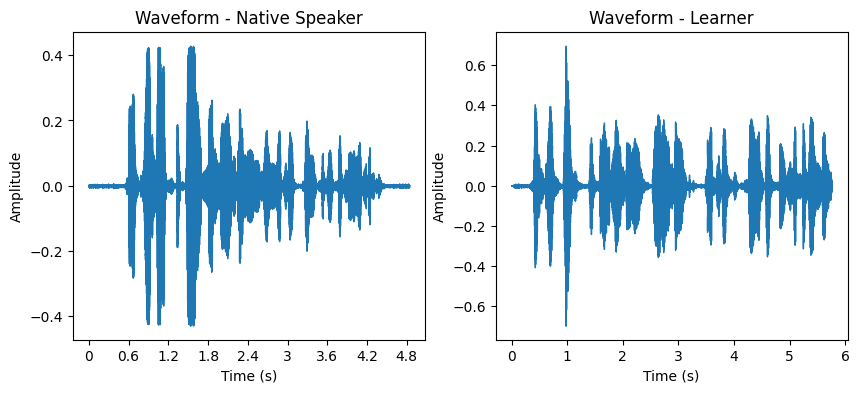

After Preprocessing:


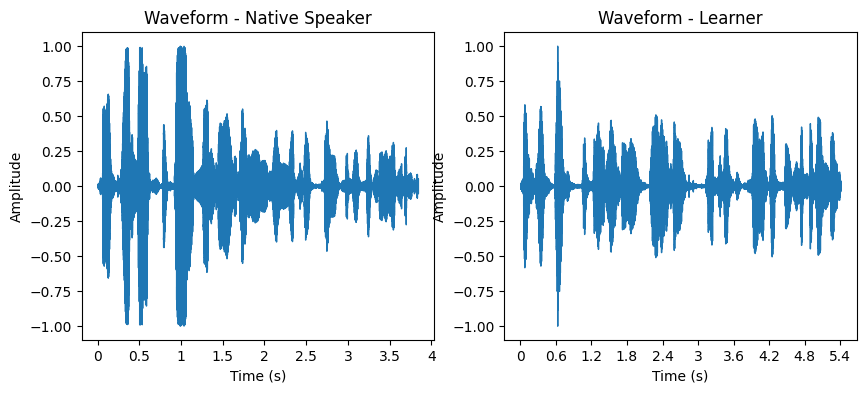

In [3]:
native_audio = "data/native_speaker/01_native.wav"
learner_audio = "data/learner/01_learner.wav"

print("Native speaker:")
display(Audio(native_audio))
print("Learner:")
display(Audio(learner_audio))

y_native, sr = librosa.load(native_audio, sr=16000)
y_learner, _ = librosa.load(learner_audio, sr=16000)
print("Before Preprocessing:")
plot_waveform(y_native, y_learner, sr)

y_native, sr = preprocess_audio(native_audio, sr=16000)
y_learner, _ = preprocess_audio(learner_audio, sr=16000)
print("After Preprocessing:")
plot_waveform(y_native, y_learner, sr)

Native features shape: (121, 21)
Learner features shape: (170, 21)


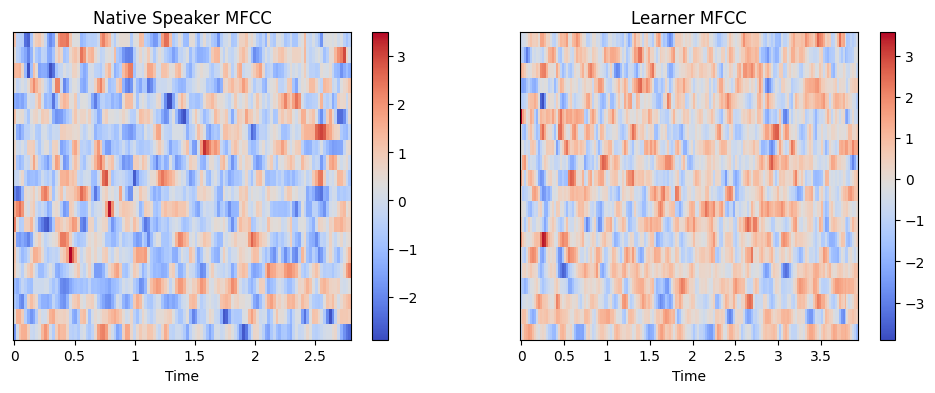

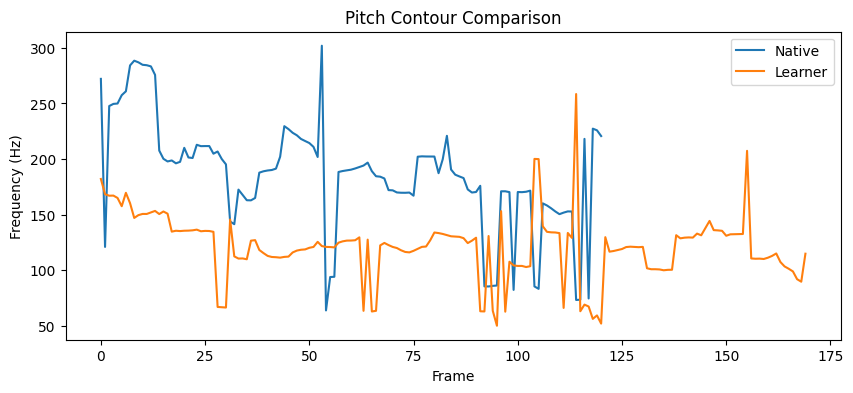

In [4]:
# Extract features
features_native = extract_mfcc_pitch(y_native, sr, n_mfcc=20)
features_learner = extract_mfcc_pitch(y_learner, sr, n_mfcc=20)

print("Native features shape:", features_native.shape)
print("Learner features shape:", features_learner.shape)

plot_mfcc(features_native[:, :-1], features_learner[:, :-1])
plot_pitch(features_native[:, -1], features_learner[:, -1])


Aligned Native shape: (262, 21)
Aligned Learner shape: (262, 21)
DTW Distance: 576.1366398378444
Average Feature Distance: 26.818011316030383
Pronunciation Score: 73.18


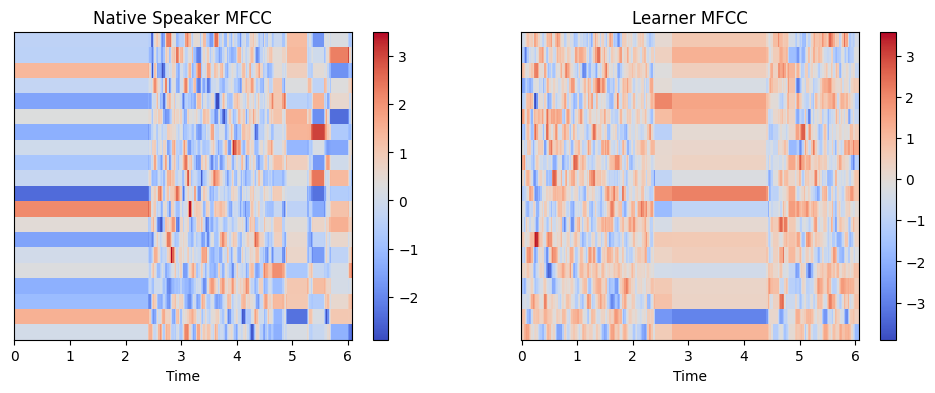

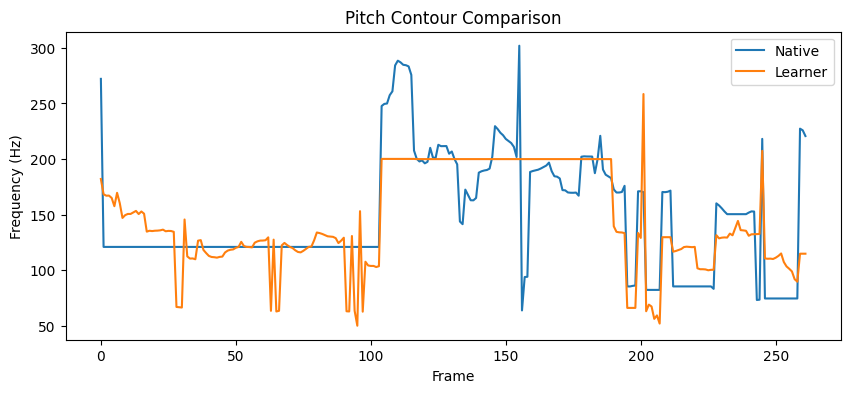

In [5]:
# DTW Alignment
aligned_native, aligned_learner, dtw_distance = dtw_alignment(features_native, features_learner)
print("Aligned Native shape:", aligned_native.shape)
print("Aligned Learner shape:", aligned_learner.shape)
print("DTW Distance:", dtw_distance)

# Pronunciation Scoring
score, avg_dist = pronunciation_score(aligned_native, aligned_learner)
print("Average Feature Distance:", avg_dist)
print("Pronunciation Score:", round(score, 2))

plot_mfcc(aligned_native[:, :-1], aligned_learner[:, :-1])
plot_pitch(aligned_native[:, -1], aligned_learner[:, -1])